# Final Project

## Library & Read Data & Font

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

plt.rcParams["font.family"] = "serif"

# load dataframe
original_df = pd.read_csv('../data/KaggleV2-May-2016.csv')
original_df.head(10)

original_df.shape

(110527, 14)

In [5]:
original_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [6]:
original_df.describe

<bound method NDFrame.describe of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       201

## Variable type and missing data

In [7]:
original_df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

array([[<AxesSubplot:title={'center':'PatientId'}>,
        <AxesSubplot:title={'center':'AppointmentID'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Scholarship'}>,
        <AxesSubplot:title={'center':'Hipertension'}>,
        <AxesSubplot:title={'center':'Diabetes'}>],
       [<AxesSubplot:title={'center':'Alcoholism'}>,
        <AxesSubplot:title={'center':'Handcap'}>,
        <AxesSubplot:title={'center':'SMS_received'}>]], dtype=object)

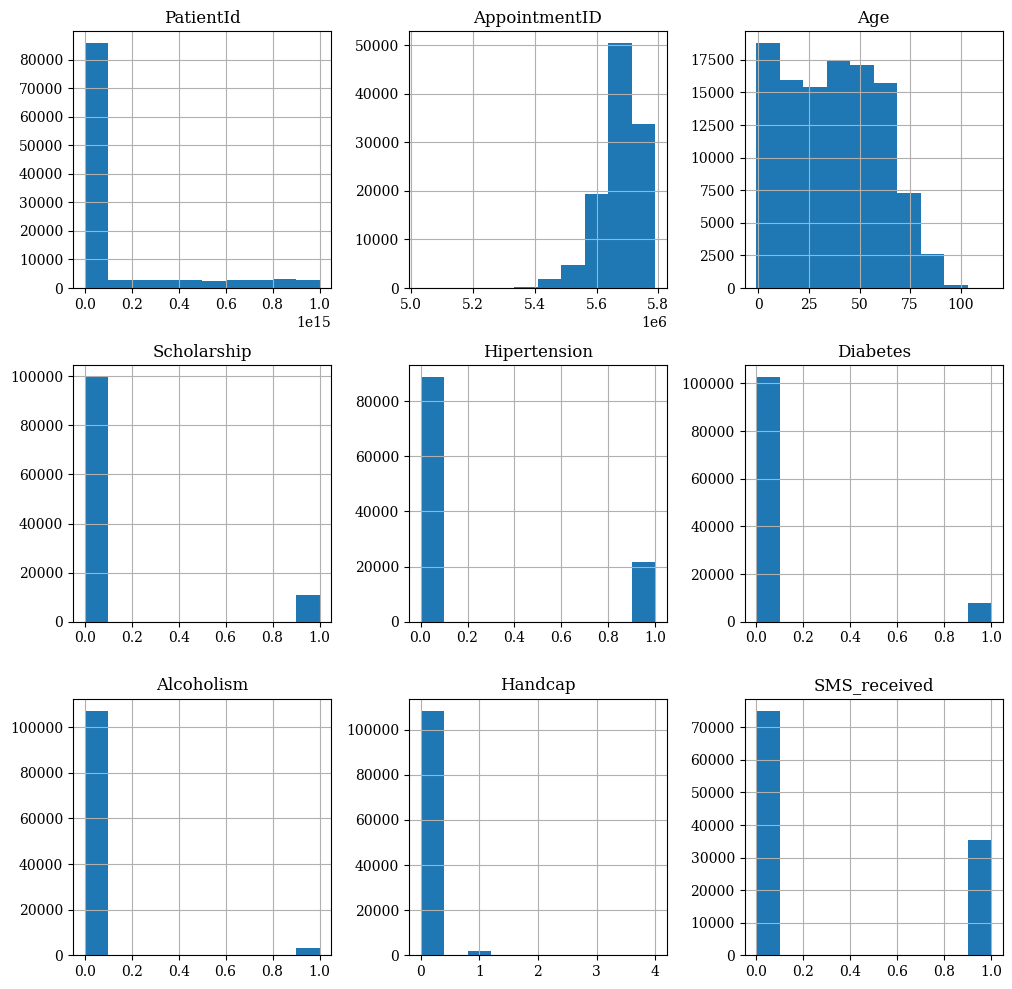

In [102]:
original_df.hist(figsize=(12, 12))

In [9]:
original_df.isna().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

Unique patient

In [10]:
len(original_df['PatientId'])
len(original_df['PatientId'].unique())
sum(original_df['PatientId'].value_counts() >= 2)

24379

AppointmentDate, Saturday, holiday

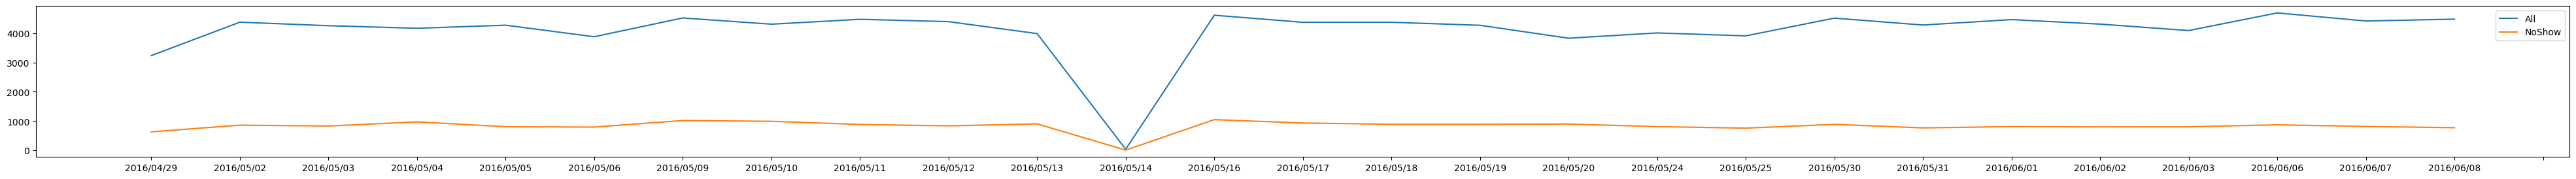

In [64]:
# check AppointmentDate
df_bydate = pd.DataFrame(index=original_df.index)
df_bydate['AppointmentDate'] = pd.to_datetime(original_df['AppointmentDay']).apply(lambda a: '{}/{:02}/{:02}'.format(a.year, a.month, a.day))
df_bydate['NoShow'] = original_df['No-show'].apply(lambda d: 1 if d == 'Yes' else 0)
df_bydate_all_noshow = pd.DataFrame(df_bydate.groupby('AppointmentDate').count())
df_bydate_all_noshow['All'] = df_bydate.groupby('AppointmentDate').count()
df_bydate_all_noshow['NoShow'] = df_bydate.groupby('AppointmentDate').sum()
df_bydate_all_noshow.reset_index(inplace=True)
plt.figure(figsize=(50, 3))
plt.plot(df_bydate_all_noshow['AppointmentDate'], df_bydate_all_noshow['All'], label='All')
plt.plot(df_bydate_all_noshow['AppointmentDate'], df_bydate_all_noshow['NoShow'], label='NoShow')
plt.xticks(np.arange(0, len(df_bydate_all_noshow['AppointmentDate']) + 1, 1))
plt.legend()
plt.show()

In [65]:
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/14')&(df_bydate['NoShow']==0)]))
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/14')&(df_bydate['NoShow']==1)]))

30
9


In [66]:
# 5/1 national holiday
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/01')&(df_bydate['NoShow']==0)]))
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/01')&(df_bydate['NoShow']==1)]))

0
0


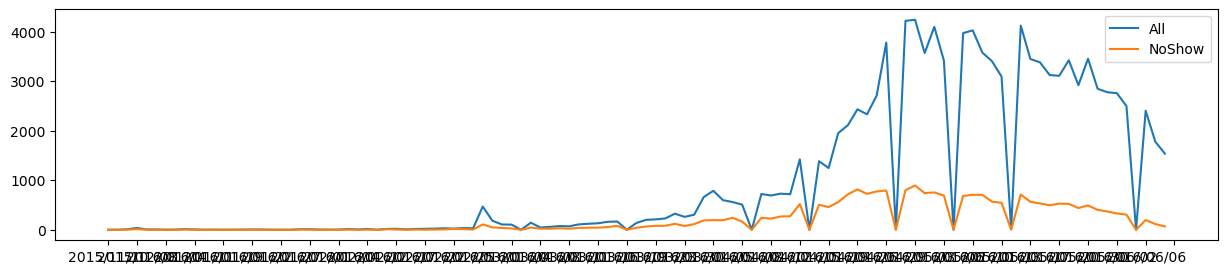

In [14]:
df_bydate = pd.DataFrame(index=original_df.index)
df_bydate['ScheduledDay'] = pd.to_datetime(original_df['ScheduledDay']).apply(lambda a: '{}/{:02}/{:02}'.format(a.year, a.month, a.day))
df_bydate['NoShow'] = original_df['No-show'].apply(lambda d: 1 if d == 'Yes' else 0)
df_bydate_all_noshow = pd.DataFrame(df_bydate.groupby('ScheduledDay').count())
df_bydate_all_noshow['All'] = df_bydate.groupby('ScheduledDay').count()
df_bydate_all_noshow['NoShow'] = df_bydate.groupby('ScheduledDay').sum()
df_bydate_all_noshow.reset_index(inplace=True)
plt.figure(figsize=(15, 3))
plt.plot(df_bydate_all_noshow['ScheduledDay'], df_bydate_all_noshow['All'], label='All')
plt.plot(df_bydate_all_noshow['ScheduledDay'], df_bydate_all_noshow['NoShow'], label='NoShow')
plt.xticks(np.arange(0, len(df_bydate_all_noshow['ScheduledDay']) + 1, 3))
plt.legend()
plt.show()

## EDA

### Target variable

In [15]:
original_df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

Classification type

In [16]:
print(sum(original_df['No-show'] == 'Yes')/original_df.shape[0])
print(sum(original_df['No-show'] == 'No')/original_df.shape[0])

0.20193255946510807
0.798067440534892


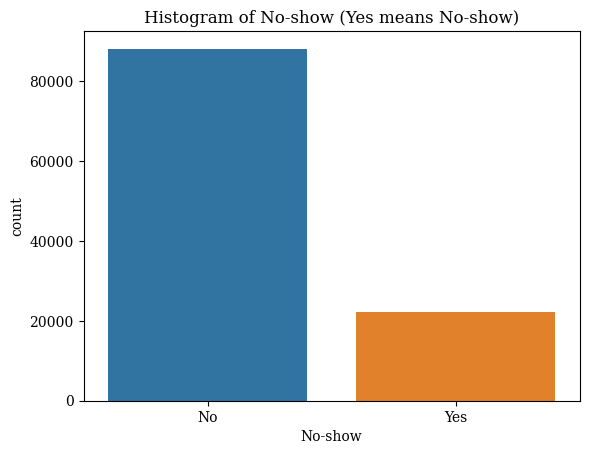

In [137]:
import seaborn
seaborn.countplot(x = original_df['No-show'])
plt.title("Histogram of No-show (Yes means No-show)")
plt.xlabel('No-show')
plt.savefig('No-show.png', dpi=300)

### Features

#### SMS_Received

<Figure size 500x300 with 0 Axes>

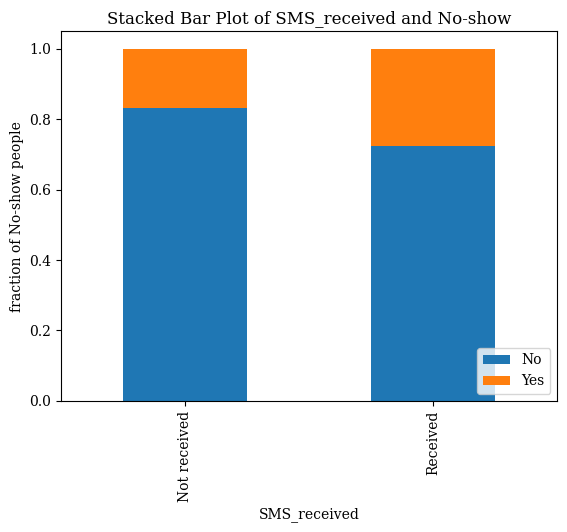

In [107]:
count_matrix = original_df.groupby(['SMS_received', 'No-show']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

plt.figure(figsize=(5,3))
count_matrix_norm.plot(kind='bar', stacked=True)
plt.xticks([0,1], ['Not received', 'Received'])
plt.title("Stacked Bar Plot of SMS_received and No-show")
plt.ylabel('fraction of No-show people')
plt.legend(loc=4)
plt.show()

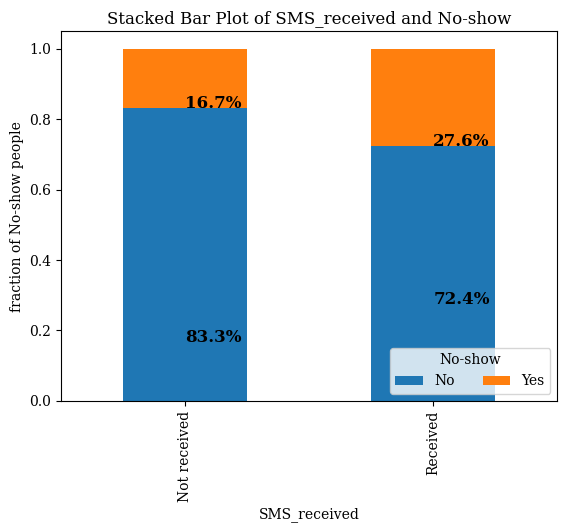

In [170]:
cross_tab_prop = pd.crosstab(index=original_df['SMS_received'],
                             columns=original_df['No-show'],
                             normalize="index")

cross_tab_prop.plot(kind='bar', 
                    stacked=True)

plt.legend(loc="lower right", ncol=2,title='No-show')
plt.xlabel("SMS_received")
plt.ylabel('fraction of No-show people')
plt.xticks([0,1], ['Not received', 'Received'])
plt.title("Stacked Bar Plot of SMS_received and No-show")
for n, x in enumerate([*cross_tab_prop.index.values]):
    for proportion in cross_tab_prop.loc[x]:
                
        plt.text(x=n,
                 y=(1-proportion),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.savefig('SMS.png', dpi=300,bbox_inches='tight')
plt.show()

In [109]:
original_df['Age'].max()

print("Patients with Age equal to -1 -> {}".format(original_df[original_df.Age == -1].shape[0]))
print("Patients with Age equal to 0 -> {}".format(original_df[original_df.Age == 0].shape[0]))

Patients with Age equal to -1 -> 1
Patients with Age equal to 0 -> 3539


In [110]:
print(len(original_df[(original_df['SMS_received']==0)&(original_df['No-show']=='Yes')])/len(original_df[(original_df['SMS_received']==0)]))
print(len(original_df[(original_df['SMS_received']==1)&(original_df['No-show']=='Yes')])/len(original_df[(original_df['SMS_received']==1)]))

0.16703311346525418
0.27574544839637


#### Age

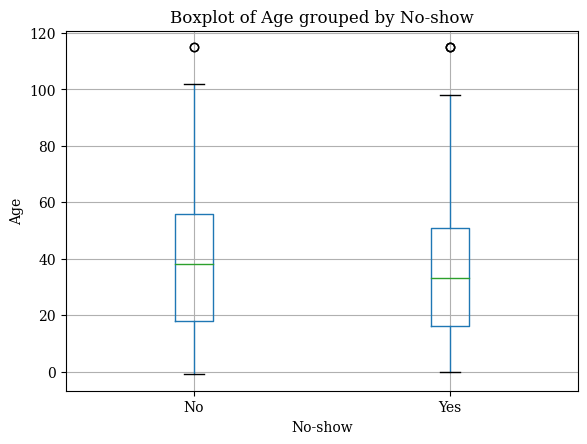

In [134]:
original_df[['Age','No-show']].boxplot(by='No-show')
plt.title("Boxplot of Age grouped by No-show")
plt.ylabel('Age')
plt.suptitle('')
plt.xlabel('No-show')
plt.savefig('Age.png', dpi=300)
plt.show()

In [173]:
original_df[original_df['Age']>110]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


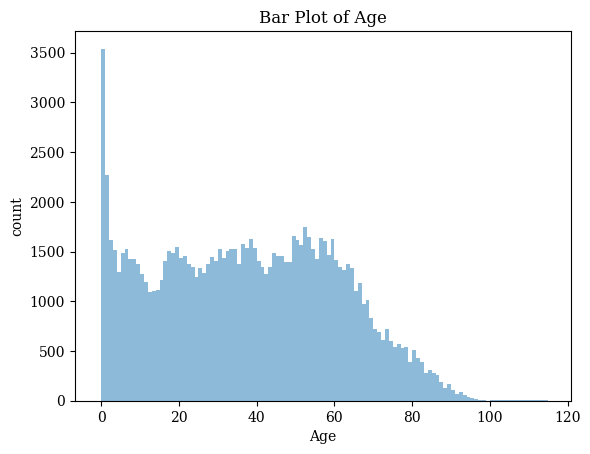

In [176]:
import matplotlib
from matplotlib import pylab as plt

bin_range = (original_df['Age'].min(),original_df['Age'].max())
plt.hist(original_df['Age'],alpha=0.5,range=bin_range,bins=np.unique(original_df['Age']))
plt.title("Bar Plot of Age")
plt.ylabel('count')
plt.xlabel('Age')
plt.savefig('Age2.png', dpi=300)
plt.show()

In [115]:
# import matplotlib
# from matplotlib import pylab as plt

# categories = original_df['No-show'].unique()
# bin_range = (original_df['Age'].min(),original_df['Age'].max())

# for c in categories:
#     plt.hist(original_df[original_df['No-show']==c]['Age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
# plt.legend()
# plt.title("Bar Plot of Age and No-show")
# plt.ylabel('fraction')
# plt.xlabel('Age')
# plt.show()

In [116]:
print(original_df['Age'].value_counts().to_string())

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
 56     1635
 38     1629
 59     1624
 2      1618
 50     1613
 57     1603
 36     1580
 51     1567
 19     1545
 39     1536
 37     1533
 54     1530
 34     1526
 33     1524
 30     1521
 6      1521
 3      1513
 17     1509
 32     1505
 5      1489
 18     1487
 44     1487
 58     1469
 46     1460
 45     1453
 21     1452
 28     1448
 31     1439
 20     1437
 7      1427
 55     1425
 8      1424
 60     1411
 29     1403
 16     1402
 40     1402
 48     1399
 47     1394
 35     1378
 27     1377
 22     1376
 63     1374
 9      1372
 23     1349
 41     1346
 43     1344
 61     1343
 25     1332
 64     1331
 62     1312
 4      1299
 26     1283
 10     1274
 42     1272
 24     1242
 15     1211
 11     1195
 66     1187
 14     1118
 13     1103
 65     1101
 12     1092
 68     1012
 67      973
 69      832
 73      725
 70      724
 71      695
 72      615
 74      602
 76      571
 75      544

#### Day of Week

In [117]:
# import seaborn as sns
# weekday = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# weekday = weekday.dt.weekday



# data = [sum(weekday==0),sum(weekday==1),sum(weekday==2),sum(weekday==3),sum(weekday==4),sum(weekday==5)]
# labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

# colors = sns.color_palette('pastel')[0:5]

# #create pie chart
# plt.pie(data, labels = labels, colors = colors, autopct='%.4f%%')
# plt.title('Day of Week Pie Chart')
# plt.show()

# print(39/110527 * 100)

Text(0.5, 23.52222222222222, 'No-show')

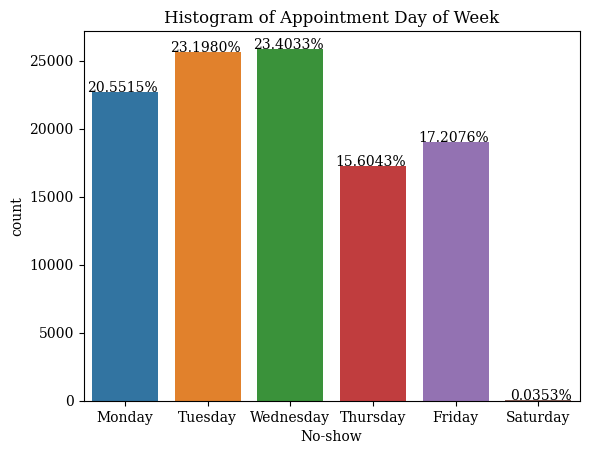

In [185]:
import seaborn

weekday = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')
weekday = weekday.dt.weekday
total = float(len(weekday))
ax=seaborn.countplot(x = weekday)
plt.xticks([0,1,2,3,4,5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title("Histogram of Appointment Day of Week")
for p in ax.patches:
    percentage = '{:.4f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.savefig('DayOfWeek.png', dpi=300)
plt.xlabel('No-show')

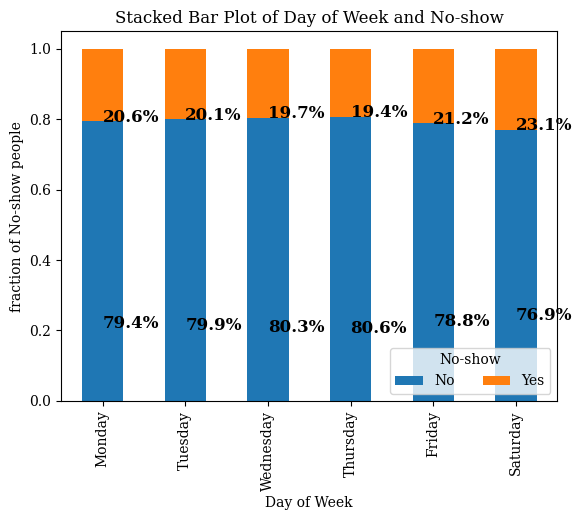

In [183]:
# df_tmp = pd.DataFrame()
# df_tmp['AppointmentDay'] = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]').dt.weekday
# df_tmp['No-show']=original_df['No-show']

# cross_tab_prop = pd.crosstab(index=df_tmp['AppointmentDay'],
#                              columns=df_tmp['No-show'],
#                              normalize="index")

# cross_tab_prop.plot(kind='bar', 
#                     stacked=True)

# plt.legend(loc="lower right", ncol=2,title='No-show')
# plt.xlabel("Day of Week")
# plt.ylabel('fraction of No-show people')
# plt.xticks([0,1,2,3,4,5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
# plt.title("Stacked Bar Plot of Day of Week and No-show")
# for n, x in enumerate([*cross_tab_prop.index.values]):
#     for proportion in cross_tab_prop.loc[x]:
                
#         plt.text(x=n,
#                  y=(1-proportion),
#                  s=f'{np.round(proportion * 100, 1)}%', 
#                  color="black",
#                  fontsize=12,
#                  fontweight="bold")
# plt.savefig('SMS.png', dpi=300,bbox_inches='tight')
# plt.show()

## Preprocessing

### Neighbourhood, one-hot

In [119]:
print(len(original_df['Neighbourhood'].unique()))
original_df['Neighbourhood'].unique()

81


array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

In [120]:
# neighbourhoods = pd.get_dummies(original_df['Neighbourhood'])
# neighbourhoods.head(50)

# features_df = pd.DataFrame()

# # get target variable, no-show as 1
# features_df['NoShow'] = original_df['No-show'].apply(lambda s: 1 if s == 'No' else 0)

# # create new data frame, and fix typo
# features_df['Age'] = original_df['Age']
# features_df['Male'] = original_df['Gender'].apply(lambda g: 1 if g == 'M' else 0) # 0 as Female, 1 as male
# features_df['Diabetes'] = original_df['Diabetes']
# features_df['Alcoholism'] = original_df['Alcoholism']
# features_df['Hypertension'] = original_df['Hipertension']
# features_df['Handicap'] = original_df['Handcap']
# features_df['Scholarship'] = original_df['Scholarship']
# features_df['SMS_received'] = original_df['SMS_received']

# # set weekday
# features_df['ScheduledDay'] = pd.to_datetime(original_df['ScheduledDay']).dt.date.astype('datetime64[ns]')
# features_df['AppointmentDay'] = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# features_df['AppointmentDayofWeek'] = features_df['AppointmentDay'].dt.weekday
# features_df = features_df.drop(['AppointmentDay'],axis=1)

# # one-hot-encoding neighbourhood

# neighbourhoods = pd.get_dummies(original_df['Neighbourhood'])
# features_df = features_df.join(neighbourhoods)

# features_df = features_df[features_df.Age >= 0]

### Preprocess

In [139]:
df = pd.DataFrame()

# get target variable, no-show as 1
df['No-show'] = original_df['No-show'].apply(lambda s: 1 if s == 'No' else 0)

# create new data frame, and fix typo
df['Age'] = original_df['Age']
df['Gender'] = original_df['Gender'].apply(lambda g: 1 if g == 'M' else 0) # 0 as Female, 1 as male
df['Diabetes'] = original_df['Diabetes']
df['Alcoholism'] = original_df['Alcoholism']
df['Hypertension'] = original_df['Hipertension']
df['Handicap'] = original_df['Handcap']
df['Scholarship'] = original_df['Scholarship']
df['SMS_received'] = original_df['SMS_received']

# set weekday
df['AppointmentDay'] = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')

df['AppointmentDayofWeek'] = df['AppointmentDay'].dt.weekday
df = df.drop(['AppointmentDay'],axis=1)

# one-hot neighbourhood

# neighbourhoods = pd.get_dummies(original_df['Neighbourhood'])
# df = df.join(neighbourhoods)

df['Neighbourhood'] = original_df['Neighbourhood']
factorize = pd.factorize(df['Neighbourhood'])
df['Neighbourhood'] = factorize[0]

df = df[df.Age >= 0]

In [184]:
df.shape

(110526, 11)

### Split

shuffle

In [160]:
X = df.loc[:, 'Age':]
y = df['No-show']

random_state = 42

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,\
                    train_size = 0.6,random_state = random_state)
print('training set:',X_train.shape, y_train.shape) # 60% of points are in train
print(X_other.shape, y_other.shape) # 40% of points are in other

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
                    train_size = 0.5,random_state = random_state)
print('validation set:',X_val.shape, y_val.shape) # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape) # 20% of points are in test

print(X_train.head())


training set: (66315, 10) (66315,)
(44211, 10) (44211,)
validation set: (22105, 10) (22105,)
test set: (22106, 10) (22106,)
        Age  Gender  Diabetes  Alcoholism  Hypertension  Handicap  \
82166    37       1         0           0             0         0   
23506    57       1         1           0             0         0   
1791     25       0         0           0             0         0   
98784     4       1         0           0             0         0   
107427   54       0         0           0             0         0   

        Scholarship  SMS_received  AppointmentDayofWeek  Neighbourhood  
82166             0             0                     1             34  
23506             0             0                     1             72  
1791              0             0                     4             10  
98784             1             0                     4             44  
107427            0             0                     4             26  


Check reprod

In [161]:
random_state = 42

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,\
                    train_size = 0.6,random_state = random_state)
print('training set:',X_train.shape, y_train.shape) # 60% of points are in train
print(X_other.shape, y_other.shape) # 40% of points are in other

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
                    train_size = 0.5,random_state = random_state)
print('validation set:',X_val.shape, y_val.shape) # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape) # 20% of points are in test

print(X_train.head())

training set: (66315, 10) (66315,)
(44211, 10) (44211,)
validation set: (22105, 10) (22105,)
test set: (22106, 10) (22106,)
        Age  Gender  Diabetes  Alcoholism  Hypertension  Handicap  \
82166    37       1         0           0             0         0   
23506    57       1         1           0             0         0   
1791     25       0         0           0             0         0   
98784     4       1         0           0             0         0   
107427   54       0         0           0             0         0   

        Scholarship  SMS_received  AppointmentDayofWeek  Neighbourhood  
82166             0             0                     1             34  
23506             0             0                     1             72  
1791              0             0                     4             10  
98784             1             0                     4             44  
107427            0             0                     4             26  


In [159]:
from sklearn.model_selection import KFold
random_state =42
X = df.loc[:, 'Age':]
y = df['No-show']

# first split to separate out the test set
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=random_state)
print(X_other.shape,y_other.shape)
print('test set:',X_test.shape,y_test.shape)

# do KFold split on other
kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    print('   training set:',X_train.shape, y_train.shape) 
    print('   validation set:',X_val.shape, y_val.shape) 
print('training set:',X_train.shape, y_train.shape) # 60% of points are in train
print('validation set:',X_val.shape, y_val.shape) # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape) # 20% of points are in test

(88420, 10) (88420,)
test set: (22106, 10) (22106,)
   training set: (70736, 10) (70736,)
   validation set: (17684, 10) (17684,)
   training set: (70736, 10) (70736,)
   validation set: (17684, 10) (17684,)
   training set: (70736, 10) (70736,)
   validation set: (17684, 10) (17684,)
   training set: (70736, 10) (70736,)
   validation set: (17684, 10) (17684,)
   training set: (70736, 10) (70736,)
   validation set: (17684, 10) (17684,)
training set: (70736, 10) (70736,)
validation set: (17684, 10) (17684,)
test set: (22106, 10) (22106,)


### encoder

In [150]:
# apply OHE to the adult dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# le = LabelEncoder()
# df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
# X_train['Neighbourhood'] = le.fit_transform(X_train['Neighbourhood'])
# X_val['Neighbourhood'] = le.fit_transform(X_val['Neighbourhood'])
# X_test['Neighbourhood'] = le.fit_transform(X_test['Neighbourhood'])

# let's collect all categorical features first
ordinal_ftrs = ['AppointmentDayofWeek','Handicap'] 
onehot_ftrs = ['Gender','Diabetes','Alcoholism','Hypertension','Scholarship','SMS_received','Neighbourhood']
minmax_ftrs = ['Age']
# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs)])
clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)





print(X_train.shape)
print(X_train_prep.shape)
print(X_train_prep)

(66315, 10)
(66315, 96)
[[1.         0.         0.         ... 0.         0.         0.32173913]
 [1.         0.         0.         ... 0.         0.         0.49565217]
 [4.         0.         1.         ... 0.         0.         0.2173913 ]
 ...
 [2.         0.         0.         ... 0.         0.         0.52173913]
 [4.         0.         1.         ... 0.         0.         0.15652174]
 [2.         0.         0.         ... 0.         0.         0.07826087]]


In [151]:
X_train.head()

,Age,Gender,Diabetes,Alcoholism,Hypertension,Handicap,Scholarship,SMS_received,AppointmentDayofWeek,Neighbourhood
82166,37,1,0,0,0,0,0,0,1,34
23506,57,1,1,0,0,0,0,0,1,72
1791,25,0,0,0,0,0,0,0,4,10
98784,4,1,0,0,0,0,1,0,4,44
107427,54,0,0,0,0,0,0,0,4,26


### f score, mi score

In [152]:
X = df.loc[:, 'Age':]
y = df['No-show']

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
np.random.seed(10)

f_test, p_values = f_classif(X, y)

for i in range(len(X_train.columns)):
    print("f socre between",X_train.columns[i], "and target variable is: ", str(f_test[i]))

f socre between Age and target variable is:  403.70201903377836
f socre between Gender and target variable is:  1.8779212022284597
f socre between Diabetes and target variable is:  25.478319793400704
f socre between Alcoholism and target variable is:  0.004282789375360946
f socre between Hypertension and target variable is:  141.06929024883144
f socre between Handicap and target variable is:  4.0815881134026215
f socre between Scholarship and target variable is:  93.88862409259988
f socre between SMS_received and target variable is:  1795.3147172208369
f socre between AppointmentDayofWeek and target variable is:  0.148325118952928
f socre between Neighbourhood and target variable is:  44.05777009513061


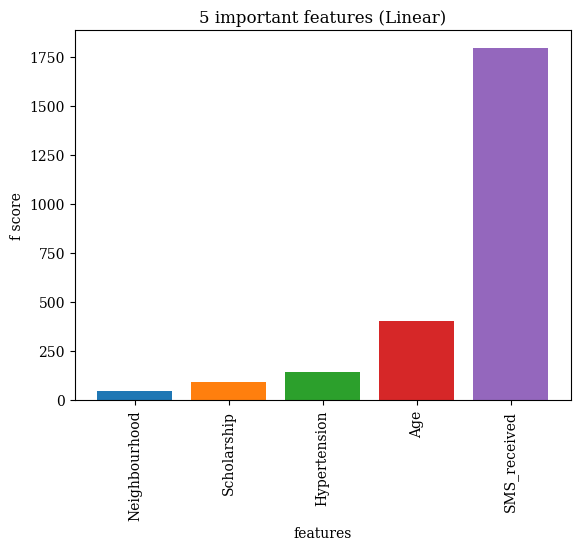

In [153]:
arr = []
for i in range(len(X_train.columns)):
    arr.append((X_train.columns[i],f_test[i]))
arr = sorted(arr, key = lambda x: x[1])
arr = arr[-5:]
for t in arr:
    plt.bar(t[0],t[1])
    plt.xticks(rotation = 90)
plt.title("5 important features (Linear)") 
plt.xlabel("features")
plt.ylabel("f score")
plt.show()

In [154]:
mi = mutual_info_classif(X, y)
for i in range(len(X_train.columns)):
    print("mi socre between",X_train.columns[i], "and target variable is: ", str(mi[i]))

mi socre between Age and target variable is:  0.005637746919122
mi socre between Gender and target variable is:  0.0012791713038564634
mi socre between Diabetes and target variable is:  0.0
mi socre between Alcoholism and target variable is:  0.0
mi socre between Hypertension and target variable is:  0.00037112403536587735
mi socre between Handicap and target variable is:  0.0
mi socre between Scholarship and target variable is:  0.0
mi socre between SMS_received and target variable is:  0.009183010884033393
mi socre between AppointmentDayofWeek and target variable is:  0.00545158571514226
mi socre between Neighbourhood and target variable is:  0.0


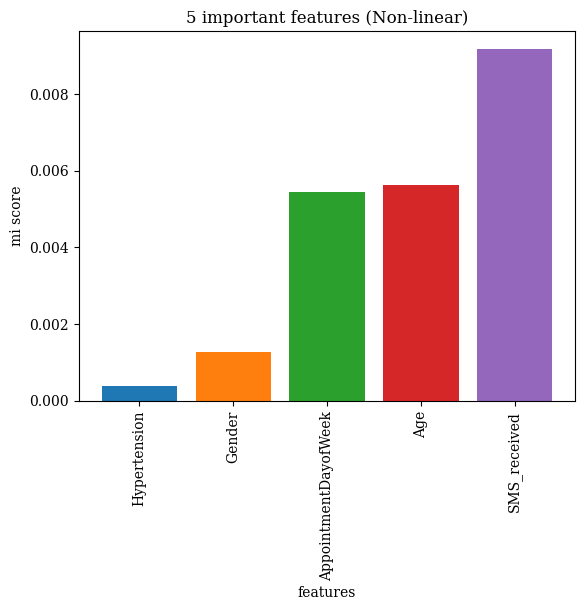

In [155]:
arr = []
for i in range(len(X_train.columns)):
    arr.append((X_train.columns[i],mi[i]))
arr = sorted(arr, key = lambda x: x[1])
arr = arr[-5:]
for t in arr:
    plt.bar(t[0],t[1])
    plt.xticks(rotation = 90)
plt.title("5 important features (Non-linear)") 
plt.xlabel("features")
plt.ylabel("mi score")
plt.show()

# After Mid Term !!!!!

In [83]:
from sklearn.metrics import classification_report

forest = RandomForestClassifier(min_samples_leaf=3, random_state=1030)
forest.fit(X_train, y_train)

print('Train score: {}'.format(forest.score(X_train, y_train)))
print('Test score: {}'.format(forest.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test, forest.predict(X_test))))

print(classification_report(y_test,forest.predict(X_test)))

Train score: 0.8184724421322476
Test score: 0.799240025332489
Confusion matrix:
[[  174  4206]
 [  232 17494]]
f1 score: 0.887
              precision    recall  f1-score   support

           0       0.43      0.04      0.07      4380
           1       0.81      0.99      0.89     17726

    accuracy                           0.80     22106
   macro avg       0.62      0.51      0.48     22106
weighted avg       0.73      0.80      0.73     22106



([<matplotlib.axis.YTick at 0x177554130>,
 [Text(0, 0, 'Handicap'),
  Text(0, 1, 'Alcoholism'),
  Text(0, 2, 'Scholarship'),
  Text(0, 3, 'Diabetes'),
  Text(0, 4, 'Hypertension'),
  Text(0, 5, 'Male'),
  Text(0, 6, 'SMS_received'),
  Text(0, 7, 'AppointmentDayofWeek'),
  Text(0, 8, 'Neighbourhood'),
  Text(0, 9, 'Age')])

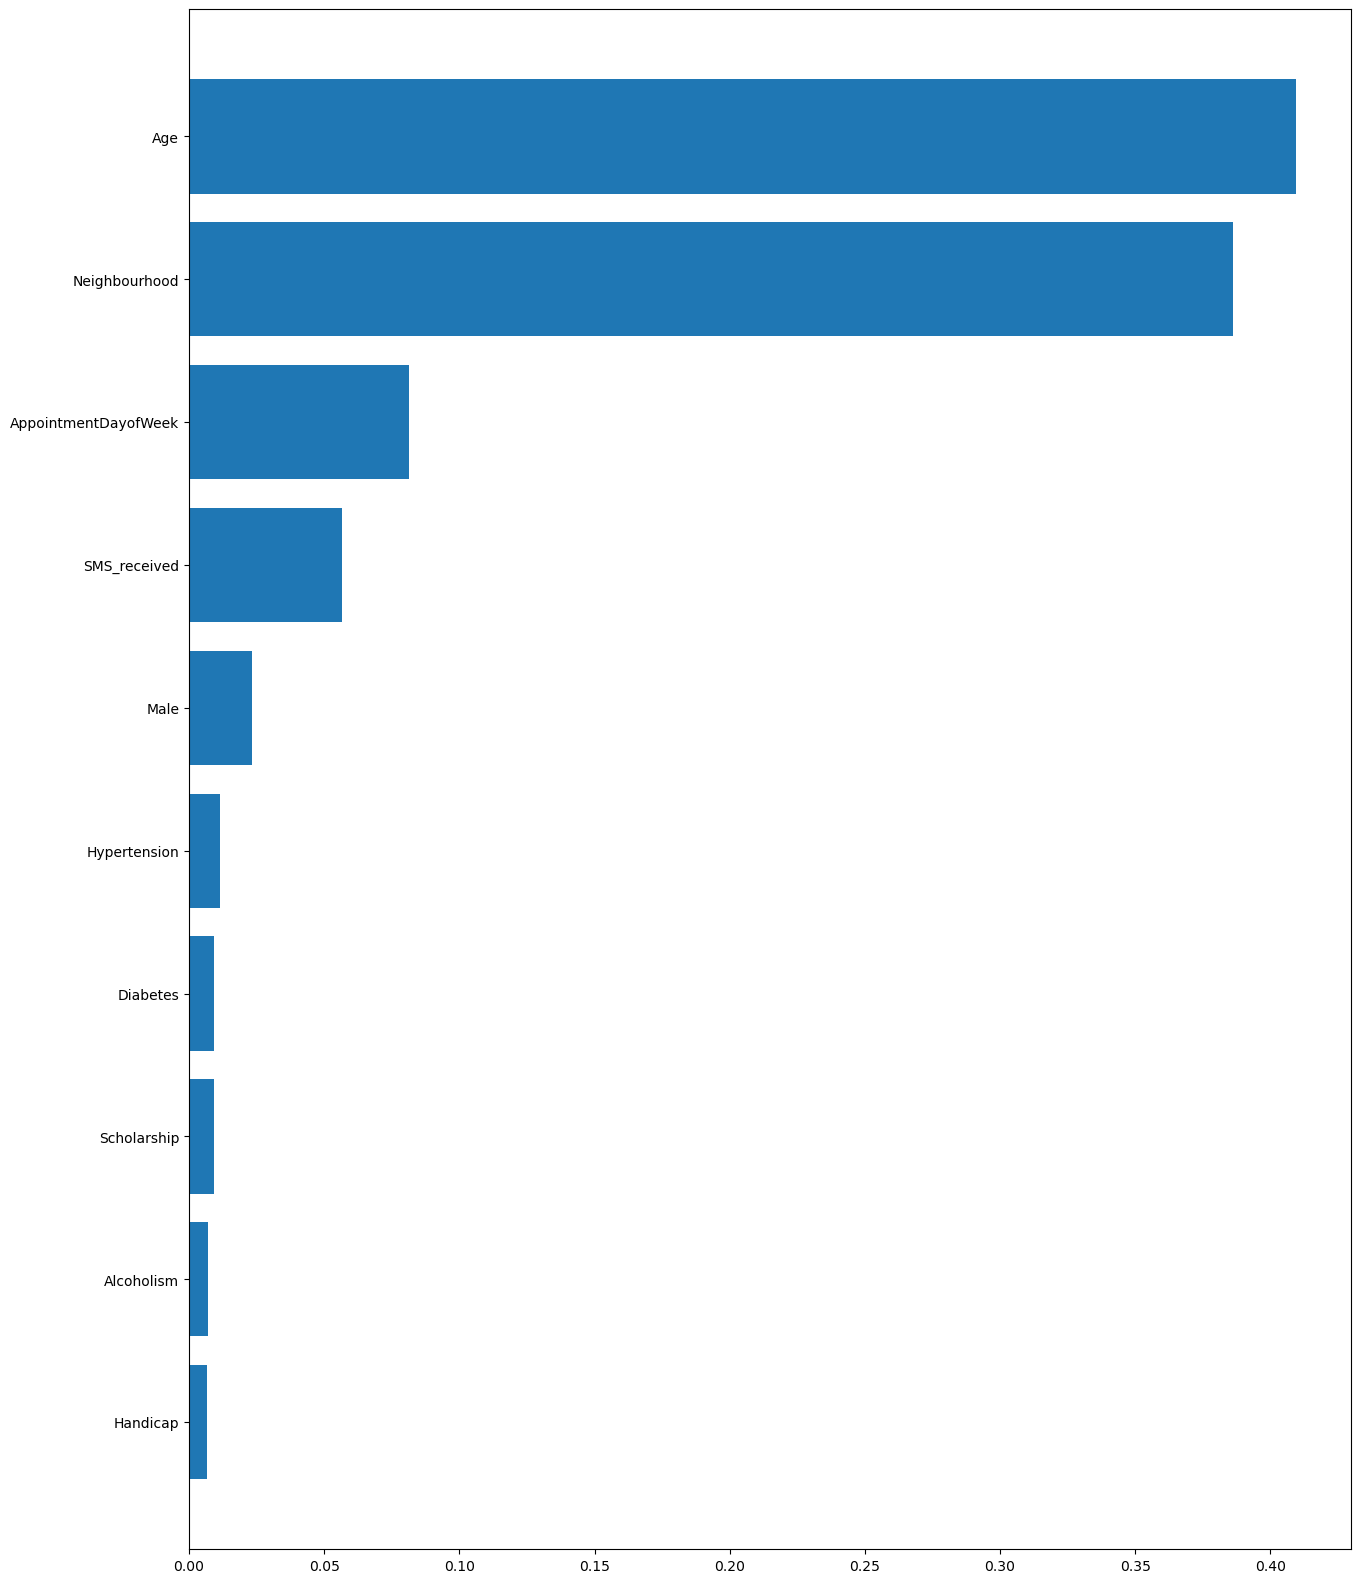

In [84]:
values, names = zip(*sorted(zip(forest.feature_importances_, X.columns)))

plt.figure(figsize=(15,20))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)

In [60]:
from sklearn.preprocessing import StandardScaler

# create StandardScaler object
scaler = StandardScaler()

# fit scaler to features
scaler.fit(df.drop(['No-show'],axis=1))

# use .transform() to transform features to scaled version
scaled_features = scaler.transform(df.drop('No-show',axis=1))

scaled_features_df = pd.DataFrame(scaled_features)
scaled_features_df.head()

,0,1,2,3,4,5,6,7,8,9
0,1.077926,-0.733842,-0.278262,-0.177068,2.017366,-0.137723,-0.330114,-0.687616,-0.122403,1.561421
1,0.818297,1.362692,-0.278262,-0.177068,-0.495696,-0.137723,-0.330114,-0.687616,-0.122403,1.561421
2,1.077926,-0.733842,-0.278262,-0.177068,-0.495696,-0.137723,-0.330114,-0.687616,0.145915,1.561421
3,-1.258733,-0.733842,-0.278262,-0.177068,-0.495696,-0.137723,-0.330114,-0.687616,0.548391,1.561421
4,0.818297,-0.733842,3.593730,-0.177068,2.017366,-0.137723,-0.330114,-0.687616,-0.122403,1.561421


In [61]:
X = scaled_features_df
y = df['No-show']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1030,  test_size=0.2)

forest1 = RandomForestClassifier(n_estimators=100, random_state=1030)

forest1.fit(X_train,y_train)
print(classification_report(y_test,forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.32      0.12      0.18      4577
           1       0.80      0.93      0.86     17529

    accuracy                           0.77     22106
   macro avg       0.56      0.53      0.52     22106
weighted avg       0.70      0.77      0.72     22106



/Users/bochenfu/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
